In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import category_encoders as ce
from sklearn.model_selection import train_test_split, KFold
import lightgbm as lgb
from dcekit.variable_selection import cvpfi

import sys
sys.path.append("/workspace/notebooks/miyas") #pathを通す
import xmodel
import preprocessing

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
seed = 42  # 乱数シード

In [2]:
#ファイルの読み込み
resultp = pd.read_csv("../csv/DS264.csv",index_col=0)

In [3]:
#前処理
resultp = resultp[resultp['VISIT']=='Screening'].drop_duplicates().reset_index(drop=True)
resultp = resultp.drop_duplicates(subset=['SUBJID','VISIT'], keep = 'last', ignore_index=True) #138名でdouble-screening
resultp = resultp[resultp["DTHDY"] != 1500.0] #要注意
resultp.drop(["OS_C"],axis=1,inplace=True) #OS_Cカラムを一旦削除
resultp.columns = [col.decode() if isinstance(col, bytes) else col for col in resultp.columns] #列名strになっているので一括変更できず

In [6]:
#欠損値EDA
print(resultp.isnull().sum())
#vitalの欠損値処理
for col in ["b'Diastolic blood pressure'","b'Pulse'","b'Respiration'","b'Systolic blood pressure'","b'Temperature'"]: #平均値
    resultp[col] = resultp[col].fillna(resultp[col].mean())
resultp["b'ECOG performance status'"] = resultp["b'ECOG performance status'"].fillna(resultp["b'ECOG performance status'"].mode()[0]) #最頻値

SUBJID                          0
b'Diastolic blood pressure'    19
b'ECOG performance status'      1
b'Pulse'                       23
b'Respiration'                 89
b'Systolic blood pressure'     19
b'Temperature'                 41
VISIT                           0
ENRREFDY                        1
ENRREFWK                        1
AGE                             0
SEXCD_b'F'                      0
SEXCD_b'M'                      0
RACCATCD                        0
TUMCAT_b'N'                     0
TUMCAT_b'Y'                     0
TRT_b'FOLFOX alone'             0
TRT_b'Panitumumab + FOLFOX'     0
PFSDYCR                         0
B_WEIGHT                        0
B_HEIGHT                        0
PFS_C                           0
EOIPRDCD                        0
DSCMPEOS                        0
ELIGIBLE_b'N'                   0
ELIGIBLE_b'Y'                   0
MHANY_b'N'                      0
MHANY_b'Y'                      0
MHBNGNYN_b'N'                   0
MHBNGNYN_b'Y' 

In [8]:
preprocessing.tag_count(resultp["RACCATCD"])

,Count
1,674
88,14


In [9]:
#one-hot encoding 
columns_cat = ["b'ECOG performance status'","RACCATCD"]
ce_ohe = ce.OneHotEncoder(cols=columns_cat, handle_unknown='impute')
resultp = ce_ohe.fit_transform(resultp)
#for col in columns_cat: #多重共線性の回避
#    result = resultp.drop([col +"_1"], axis=1)

In [10]:
#OSの再設定
median_os = np.nanmedian(resultp['DTHDY']) # DTHDYカラムの中央値を求める
print(f'中央値 = {median_os}')
resultp.loc[resultp['DTHDY'] >= median_os, 'OS_C'] = 1
resultp.loc[resultp['DTHDY'] < median_os, 'OS_C'] = 0

中央値 = 465.5


In [11]:
#カラム確認
print(resultp.columns)

Index(['SUBJID', 'b'Diastolic blood pressure'', 'b'ECOG performance status'_1',
       'b'ECOG performance status'_2', 'b'ECOG performance status'_3',
       'b'Pulse'', 'b'Respiration'', 'b'Systolic blood pressure'',
       'b'Temperature'', 'VISIT', 'ENRREFDY', 'ENRREFWK', 'AGE', 'SEXCD_b'F'',
       'SEXCD_b'M'', 'RACCATCD_1', 'RACCATCD_2', 'TUMCAT_b'N'', 'TUMCAT_b'Y'',
       'TRT_b'FOLFOX alone'', 'TRT_b'Panitumumab + FOLFOX'', 'PFSDYCR',
       'B_WEIGHT', 'B_HEIGHT', 'PFS_C', 'EOIPRDCD', 'DSCMPEOS',
       'ELIGIBLE_b'N'', 'ELIGIBLE_b'Y'', 'MHANY_b'N'', 'MHANY_b'Y'',
       'MHBNGNYN_b'N'', 'MHBNGNYN_b'Y'', 'OTANY_b'N'', 'OTANY_b'Y'', 'OTSTDY',
       'OTENDY', 'RAANY_b'N'', 'RAANY_b'Y'', 'DTHDY', 'OS_binary', 'OS_C'],
      dtype='object')


### 試験内予測⑦-1
岩井さんから頂いたtrain.csv(プリセールス引継ぎ?)のみを用いてまずは試験内予測  
試験：DS264  
問題設定：OSの分類タスク  
目的変数：OS(DTH=1.0)  
モデル：LightGBM

In [7]:
#特徴量指定 
"""
確実にリークしていないであろうものだけを選定
"""
X_columns = ["b'Diastolic blood pressure'","b'ECOG performance status'_2","b'ECOG performance status'_3","b'Pulse'","b'Respiration'",
            "b'Systolic blood pressure'","b'Temperature'",'AGE',"SEXCD_b'M'",'RACCATCD',"TUMCAT_b'Y'","TRT_b'Panitumumab + FOLFOX'",'B_WEIGHT','B_HEIGHT',
            "MHANY_b'Y'","MHBNGNYN_b'Y'","OTANY_b'Y'","RAANY_b'Y'"]
y_column =  "OS_C"

#入力データ
X = resultp[X_columns].sort_index(axis = 1, ascending = True) #列名をソート
y = resultp[y_column]

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

In [8]:
#多重共線性の確認
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame() #初期化
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

    VIF Factor                      features
0    47.742741                           AGE
1   697.545745                      B_HEIGHT
2    35.442654                      B_WEIGHT
3    14.347122                    MHANY_b'Y'
4     1.472582                 MHBNGNYN_b'Y'
5     1.598119                    OTANY_b'Y'
6     1.779762                    RAANY_b'Y'
7     1.081181                      RACCATCD
8     5.300019                    SEXCD_b'M'
9     2.004095   TRT_b'Panitumumab + FOLFOX'
10    4.094848                   TUMCAT_b'Y'
11  120.301510   b'Diastolic blood pressure'
12    1.930591  b'ECOG performance status'_2
13    1.187728  b'ECOG performance status'_3
14   54.231900                      b'Pulse'
15   39.826047                b'Respiration'
16  140.810209    b'Systolic blood pressure'
17  801.536758                b'Temperature'


In [9]:
#多重共線性対応後のカラム確認
preprocessing.avoid_multicollinearity(X)[1] 

,VIF Factor,features
0,5.948699,MHANY_b'Y'
1,1.390065,MHBNGNYN_b'Y'
2,1.548011,OTANY_b'Y'
3,1.690349,RAANY_b'Y'
4,1.059828,RACCATCD
5,2.612026,SEXCD_b'M'
6,1.909330,TRT_b'Panitumumab + FOLFOX'
7,3.533048,TUMCAT_b'Y'
8,1.758111,b'ECOG performance status'_2
9,1.133070,b'ECOG performance status'_3


[I 2024-02-13 06:23:57,860] A new study created in memory with name: no-name-14c92565-cf35-4683-b46f-56ff3b056956
[I 2024-02-13 06:24:00,207] Trial 0 finished with value: 0.5839064262891169 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403, 'num_leaves': 376, 'feature_fraction': 0.759195090518222, 'bagging_fraction': 0.4936111842654619, 'bagging_freq': 1, 'min_child_samples': 10}. Best is trial 0 with value: 0.5839064262891169.
[I 2024-02-13 06:24:01,511] Trial 1 finished with value: 0.5880557330655453 and parameters: {'lambda_l1': 0.6245760287469893, 'lambda_l2': 0.002570603566117598, 'num_leaves': 363, 'feature_fraction': 0.41235069657748147, 'bagging_fraction': 0.9819459112971965, 'bagging_freq': 9, 'min_child_samples': 25}. Best is trial 1 with value: 0.5880557330655453.
[I 2024-02-13 06:24:01,756] Trial 2 finished with value: 0.5722733405580861 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07, 'num_leaves':

Number of finished trials: 100
最適パラメータ {'lambda_l1': 2.195335246183708e-05, 'lambda_l2': 2.2558517888054914e-07, 'num_leaves': 3, 'feature_fraction': 0.9621729017085076, 'bagging_fraction': 0.9427311446905419, 'bagging_freq': 3, 'min_child_samples': 29}
スコア 0.6257900841521111
所要時間50.74274778366089秒
正解率 =  0.622093023255814

auc : 0.641285


<Figure size 1000x600 with 0 Axes>

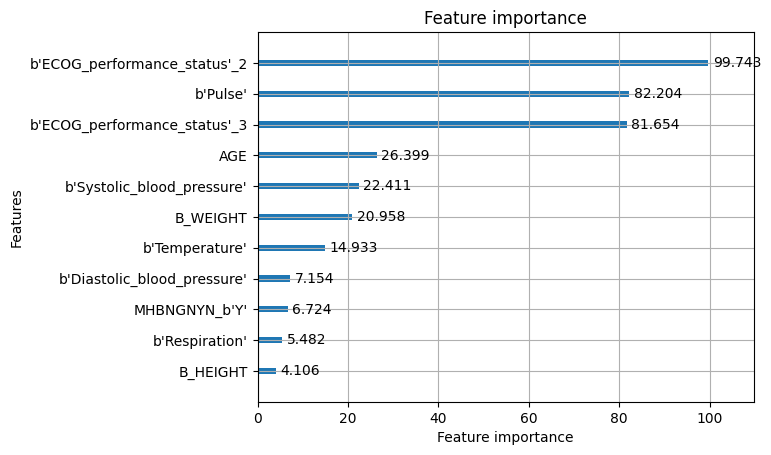

In [10]:
#学習設定
cv = KFold(n_splits=5, shuffle=True, random_state=seed) # 5分割KFoldでクロスバリデーション分割指定
scoring = scoring = 'roc_auc' #評価指標

#ハイパーパラメーターチューニング<3>
best_params = xmodel.Hypara_T(X,y,cv,n_trials=100)[0] #ハイパーパラメーターチューニング<3>
params = dict({'objective': 'binary',
                'boosting': 'gbdt',
                'metric': 'binary_logloss',
                'learning_rate': 0.05,
                'seed': 42,
                'verbosity': -1
                },**best_params)

#モデル学習と可視化
y_pred, model =  xmodel.Lgb_bC(X_train, y_train, X_test, y_test, params)

### 試験内予測⑦-2
岩井さんから頂いたtrain.csv(vital)+lab_train.csvを用いて試験内予測  
試験：DS264  
問題設定：OSの分類タスク  
目的変数：OS(DTH=1.0)  
モデル：LightGBM

In [25]:
#ファイルの読み込み
lab = pd.read_csv("../csv/lab_train.csv",index_col=0)

In [26]:
#前処理
lab.reset_index(inplace= True)
lab = lab.rename(columns={'index': 'SUBJID'})
lab = lab[lab['VISIT']=='Screening'].drop_duplicates().reset_index(drop=True)
lab = lab.drop_duplicates(subset=['SUBJID','VISIT'], keep = 'last', ignore_index=True) #lab["SUBJID"].duplicated().sum() ->314
lab = lab[lab["DTHDY"] != 1500.0] 

LBSTNRLO_columns = [s for s in lab.columns if "LBSTNRLO_" in s]
LBSTNRHI_columns = [s for s in lab.columns if "LBSTNRHI_" in s]
Above_columns = [s for s in lab.columns if "Above_" in s]
Below_columns = [s for s in lab.columns if "Below_" in s]
lab.drop(["OS_C"]+LBSTNRLO_columns+LBSTNRHI_columns+Above_columns+Below_columns,axis=1,inplace=True) 

In [27]:
#欠損値EDA
print(lab.isnull().sum())

#欠損値処理
"""
GBDTモデルは欠損値を埋めずにそのまま入力することができる
"""
lab.drop(["LBBLRES_b'Blood Urea Nitrogen'","LBBLRES_b'Granulocytes'"],axis=1,inplace=True) #欠損値の多いUNと顆粒球は削除
LBBLRES_columns = [s for s in lab.columns if "LBBLRES_" in s]
for col in LBBLRES_columns: #平均値
    lab[col] = lab[col].fillna(lab[col].mean())

SUBJID                                      0
VISIT                                       0
ENRREFDY                                    0
ENRREFWK                                    0
LBBLRES_b'Absolute Neutrophil Count'       56
LBBLRES_b'Alanine Amino Transferase'       38
LBBLRES_b'Albumin'                         61
LBBLRES_b'Alkaline Phosphatase'            46
LBBLRES_b'Aspartate Amino Transferase'     40
LBBLRES_b'Basophils'                       88
LBBLRES_b'Bicarbonate'                    157
LBBLRES_b'Blood Urea Nitrogen'            607
LBBLRES_b'Calcium'                         46
LBBLRES_b'Carcinoembryonic Antigen'       194
LBBLRES_b'Chloride'                        66
LBBLRES_b'Creatinine'                      39
LBBLRES_b'Eosinophils'                     72
LBBLRES_b'Granulocytes'                   675
LBBLRES_b'Hematocrit'                      55
LBBLRES_b'Hemoglobin'                      55
LBBLRES_b'Lactate Dehydrogenase'           60
LBBLRES_b'Lymphocytes'            

In [34]:
#マージ
vila = preprocessing.merge_dataframes([resultp,lab[["SUBJID"]+LBBLRES_columns]])
print(vila.columns)

Index(['SUBJID', 'b'Diastolic blood pressure'', 'b'ECOG performance status'_1',
       'b'ECOG performance status'_2', 'b'ECOG performance status'_3',
       'b'Pulse'', 'b'Respiration'', 'b'Systolic blood pressure'',
       'b'Temperature'', 'VISIT', 'ENRREFDY', 'ENRREFWK', 'AGE', 'SEXCD_b'F'',
       'SEXCD_b'M'', 'RACCATCD_1', 'RACCATCD_2', 'TUMCAT_b'N'', 'TUMCAT_b'Y'',
       'TRT_b'FOLFOX alone'', 'TRT_b'Panitumumab + FOLFOX'', 'PFSDYCR',
       'B_WEIGHT', 'B_HEIGHT', 'PFS_C', 'EOIPRDCD', 'DSCMPEOS',
       'ELIGIBLE_b'N'', 'ELIGIBLE_b'Y'', 'MHANY_b'N'', 'MHANY_b'Y'',
       'MHBNGNYN_b'N'', 'MHBNGNYN_b'Y'', 'OTANY_b'N'', 'OTANY_b'Y'', 'OTSTDY',
       'OTENDY', 'RAANY_b'N'', 'RAANY_b'Y'', 'DTHDY', 'OS_binary', 'OS_C',
       'LBBLRES_b'Absolute Neutrophil Count'',
       'LBBLRES_b'Alanine Amino Transferase'', 'LBBLRES_b'Albumin'',
       'LBBLRES_b'Alkaline Phosphatase'',
       'LBBLRES_b'Aspartate Amino Transferase'', 'LBBLRES_b'Basophils'',
       'LBBLRES_b'Bicarbonate'', '

In [43]:
#特徴量指定 
"""
確実にリークしていないであろうものだけを選定
"""
X_columns = list(set(vila.columns) - set(['SUBJID', 'VISIT', 'ENRREFDY', 'ENRREFWK', 'PFSDYCR','PFS_C', 'EOIPRDCD', 'DSCMPEOS',
       "ELIGIBLE_b'N'", "ELIGIBLE_b'Y'", "MHANY_b'N'", "MHANY_b'Y'","MHBNGNYN_b'N'", "MHBNGNYN_b'Y'", "OTANY_b'N'", "OTANY_b'Y'", 'OTSTDY',
       'OTENDY', "RAANY_b'N'", "RAANY_b'Y'", 'DTHDY', 'OS_binary',"OS_C"]))
y_column =  "OS_C"

#入力データ
X = vila[X_columns].sort_index(axis = 1, ascending = True) #列名をソート
y = vila[y_column]

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

[I 2024-02-18 10:20:53,874] A new study created in memory with name: no-name-8a443f0d-58cb-48a6-a226-416b5bd413b9
[I 2024-02-18 10:20:56,110] Trial 0 finished with value: 0.6489693444552656 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403, 'num_leaves': 376, 'feature_fraction': 0.759195090518222, 'bagging_fraction': 0.4936111842654619, 'bagging_freq': 1, 'min_child_samples': 10}. Best is trial 0 with value: 0.6489693444552656.
[I 2024-02-18 10:20:56,908] Trial 1 finished with value: 0.6517182598082909 and parameters: {'lambda_l1': 0.6245760287469893, 'lambda_l2': 0.002570603566117598, 'num_leaves': 363, 'feature_fraction': 0.41235069657748147, 'bagging_fraction': 0.9819459112971965, 'bagging_freq': 9, 'min_child_samples': 25}. Best is trial 1 with value: 0.6517182598082909.
[I 2024-02-18 10:20:57,319] Trial 2 finished with value: 0.6574638359017599 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07, 'num_leaves':

Number of finished trials: 100
最適パラメータ {'lambda_l1': 6.316978743669669e-05, 'lambda_l2': 0.001440539961296565, 'num_leaves': 230, 'feature_fraction': 0.7244855379118944, 'bagging_fraction': 0.9145692235096083, 'bagging_freq': 1, 'min_child_samples': 33}
スコア 0.6691216226757704
所要時間64.36765217781067秒
正解率 =  0.5872093023255814

auc : 0.676692


<Figure size 1000x600 with 0 Axes>

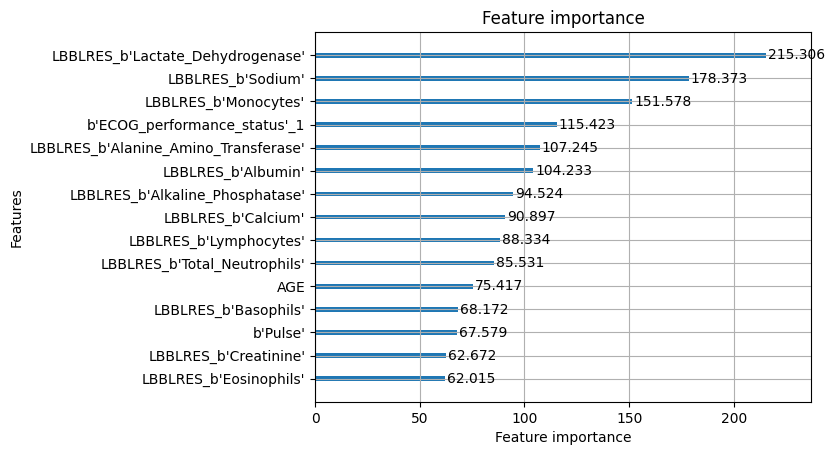

In [44]:
#学習設定
cv = KFold(n_splits=5, shuffle=True, random_state=seed) # 5分割KFoldでクロスバリデーション分割指定

#ハイパーパラメーターチューニング<3>
best_params = xmodel.Hypara_T(X,y,cv,n_trials=100)[0] #ハイパーパラメーターチューニング<3>
params = dict({'objective': 'binary',
                'boosting': 'gbdt',
                'metric': 'binary_logloss',
                'learning_rate': 0.05,
                'seed': 42,
                'verbosity': -1
                },**best_params)

#モデル学習と可視化
y_pred, model =  xmodel.Lgb_bC(X_train, y_train, X_test, y_test, params)

### CPVFIの実装

[I 2024-02-18 10:21:58,697] A new study created in memory with name: no-name-7ded6af3-dd61-4c72-a2df-e7d448743ec8
[I 2024-02-18 10:22:31,354] Trial 0 finished with value: 0.6481185793565036 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403, 'num_leaves': 376, 'feature_fraction': 0.759195090518222, 'bagging_fraction': 0.4936111842654619, 'bagging_freq': 1, 'min_child_samples': 10}. Best is trial 0 with value: 0.6481185793565036.
[I 2024-02-18 10:22:57,711] Trial 1 finished with value: 0.6430923404085773 and parameters: {'lambda_l1': 0.6245760287469893, 'lambda_l2': 0.002570603566117598, 'num_leaves': 363, 'feature_fraction': 0.41235069657748147, 'bagging_fraction': 0.9819459112971965, 'bagging_freq': 9, 'min_child_samples': 25}. Best is trial 0 with value: 0.6481185793565036.
[I 2024-02-18 10:23:02,107] Trial 2 finished with value: 0.6359533002770501 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07, 'num_leaves':

Number of finished trials: 100
最適パラメータ {'lambda_l1': 0.0031940914154258977, 'lambda_l2': 4.359606232186779e-08, 'num_leaves': 301, 'feature_fraction': 0.5937804320218902, 'bagging_fraction': 0.4270592367600872, 'bagging_freq': 10, 'min_child_samples': 87}
スコア 0.6581451167656132
所要時間399.1498110294342秒


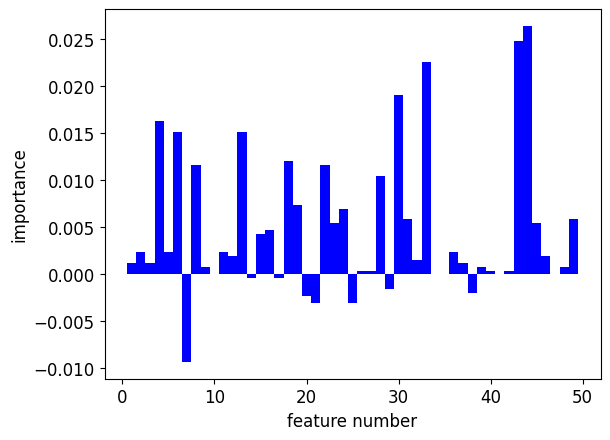

In [45]:
#ハイパーパラメーターチューニング<4> -Scikit-learn API
best_params = xmodel.Hypara_S(X,y,cv,scoring='roc_auc',n_trials=100)[0]
params = dict({'objective': 'binary',
                'boosting': 'gbdt',
                'metric': 'binary_logloss',
                'learning_rate': 0.05,
                'seed': 42,
                'verbosity': -1
                },**best_params)
model =  lgb.LGBMClassifier(**params) #Scikit-learn API

# settings
n_repeats = 5  # the number of repetition J
alpha_r = 0.999  # alpha (the significance level) in the r (correlation) consideration, 1 means the correlations between features are not considered 

# CVPFI calculation
importances_mean, importances_std, importances = cvpfi(
    model,
    X_train,
    y_train,
    fold_number=5,
    scoring='accuracy',
    n_repeats=n_repeats,
    alpha_r=alpha_r,
    random_state=seed,
)

plt.rcParams['font.size'] = 12
plt.bar(range(1, X_train.shape[1] + 1), importances_mean[range(0, X_train.shape[1])], color='b', width=1)
plt.xlabel('x')
plt.xlabel('feature number')
plt.ylabel('importance')
plt.show()

In [46]:
CPVFI =  pd.DataFrame(importances_mean[range(0, X_train.shape[1])],
                  columns=['Feature importance'],
                  index=X_train.columns)
print(CPVFI)
#CPVFI.to_csv('../csv/CPFVI.csv')

                                        Feature importance
AGE                                               0.001163
B_HEIGHT                                          0.002326
B_WEIGHT                                          0.001163
LBBLRES_b'Absolute Neutrophil Count'              0.016279
LBBLRES_b'Alanine Amino Transferase'              0.002326
LBBLRES_b'Albumin'                                0.015116
LBBLRES_b'Alkaline Phosphatase'                  -0.009302
LBBLRES_b'Aspartate Amino Transferase'            0.011628
LBBLRES_b'Basophils'                              0.000775
LBBLRES_b'Bicarbonate'                            0.000000
LBBLRES_b'Calcium'                                0.002326
LBBLRES_b'Carcinoembryonic Antigen'               0.001938
LBBLRES_b'Chloride'                               0.015116
LBBLRES_b'Creatinine'                            -0.000388
LBBLRES_b'Eosinophils'                            0.004264
LBBLRES_b'Hematocrit'                             0.0046